<a href="https://colab.research.google.com/github/aashrithresearch/WoundAI/blob/main/models/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import *
import torch
import os

In [ ]:
from google.colab import files
files.upload()

In [4]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download 'ibrahimfateen/wound-classification'

Dataset URL: https://www.kaggle.com/datasets/ibrahimfateen/wound-classification
License(s): unknown
 99% 89.0M/89.8M [00:05<00:00, 26.5MB/s]
100% 89.8M/89.8M [00:05<00:00, 17.2MB/s]


In [ ]:
! unzip /content/wound-classification.zip -d /content

In [7]:
fnames = '/content/Wound_dataset copy'

In [8]:
dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y = parent_label,
                   splitter = RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms = Resize(224),
                   batch_tfms = aug_transforms(mult=2))
dls = dblock.dataloaders(fnames, bs=32)

In [9]:
train_ds = dls.train_ds
dls = dblock.dataloaders(fnames)
from collections import Counter
class_counts = Counter([train_ds.items[i].parent.name for i in range(len(train_ds))])

print("Number of samples per class in the training set:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

Number of samples per class in the training set:
Pressure Wounds: 487
Surgical Wounds: 344
Diabetic Wounds: 374
Bruises: 190
Burns: 102
Venous Wounds: 387
Normal: 165
Laseration: 102
Abrasions: 128
Cut: 73


In [10]:
valid_ds = dls.valid_ds
valid_class_counts = Counter([valid_ds.items[i].parent.name for i in range(len(valid_ds))])


print("\nNumber of samples per class in the validation set:")
for cls, count in valid_class_counts.items():
    print(f"{cls}: {count}")


Number of samples per class in the validation set:
Diabetic Wounds: 88
Pressure Wounds: 115
Abrasions: 36
Venous Wounds: 107
Bruises: 52
Laseration: 20
Normal: 35
Cut: 27
Surgical Wounds: 76
Burns: 32


In [11]:
from math import ceil
batch = dls.one_batch()
batch_size = batch[0].shape[0]
ncols = 10
nrows = ceil(batch_size / ncols)

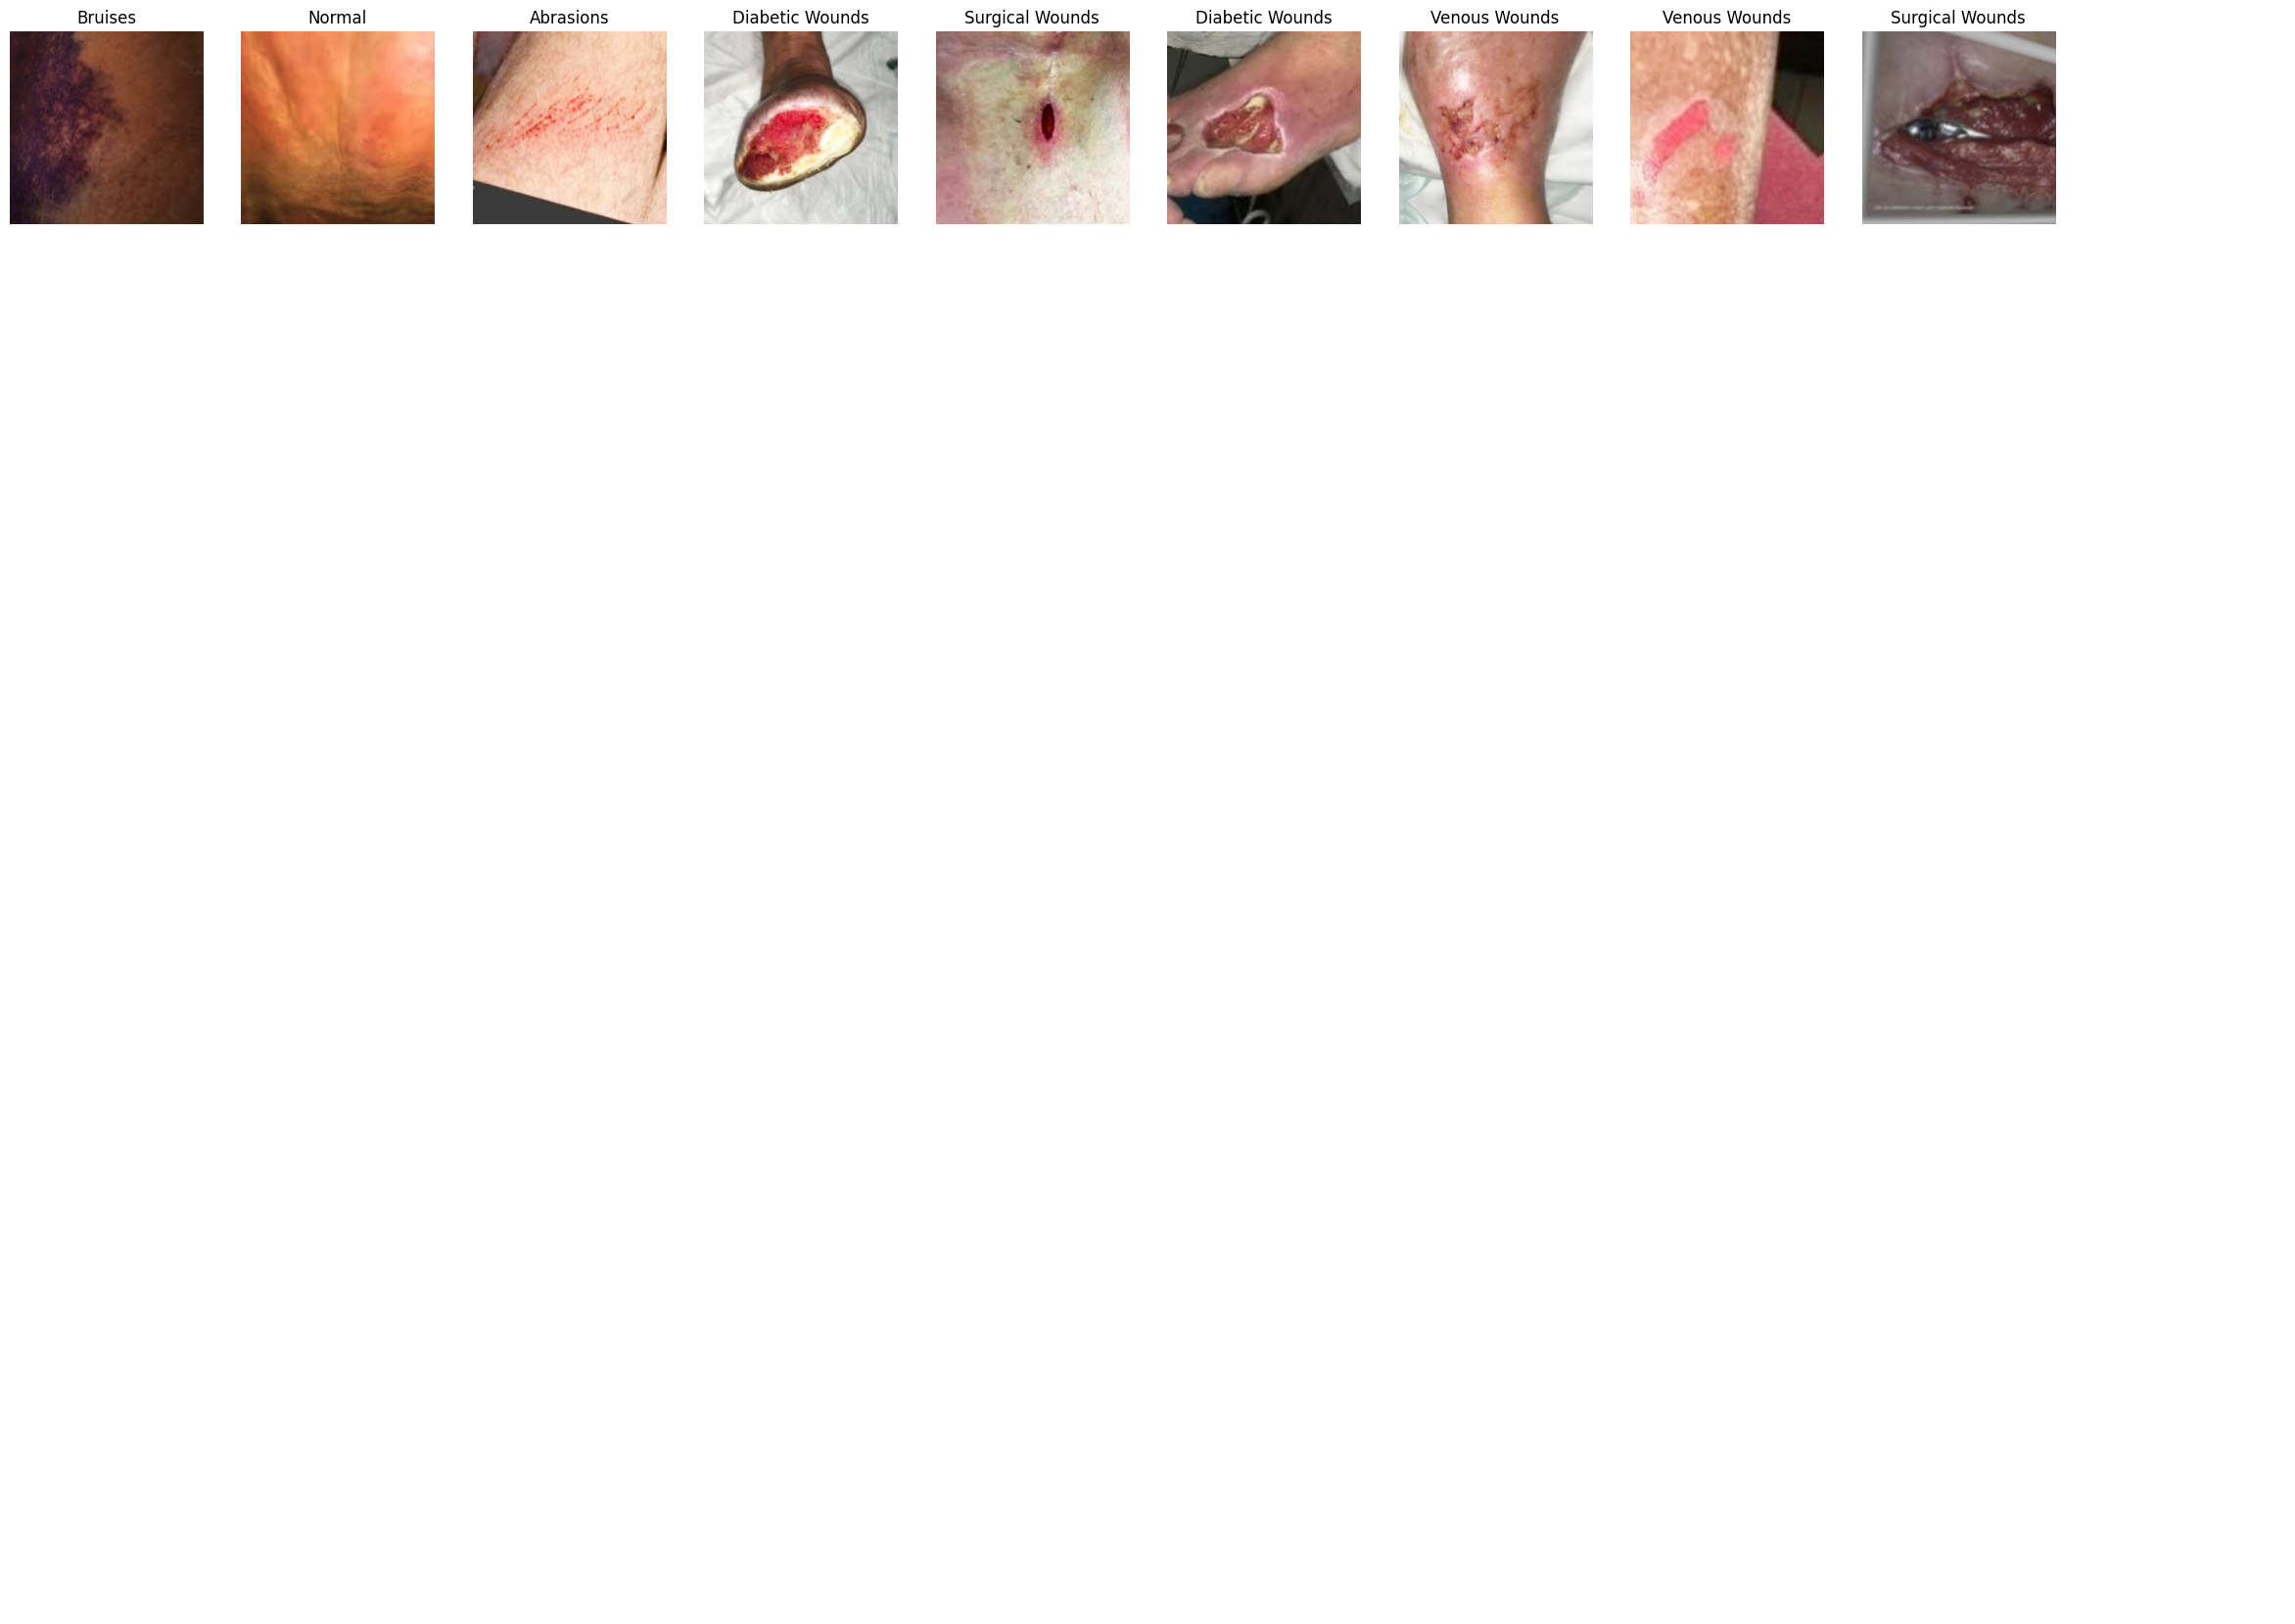

In [12]:
dls.show_batch(nrows=nrows, ncols=10)

In [13]:
metrics =  [
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro'),
    RocAuc(average='macro')
]
learn16 = vision_learner(dls, vgg16, metrics=metrics, loss_func=FocalLoss(), opt_func=Adam).to_fp16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 59.3MB/s]


SuggestedLRs(valley=0.0014454397605732083)

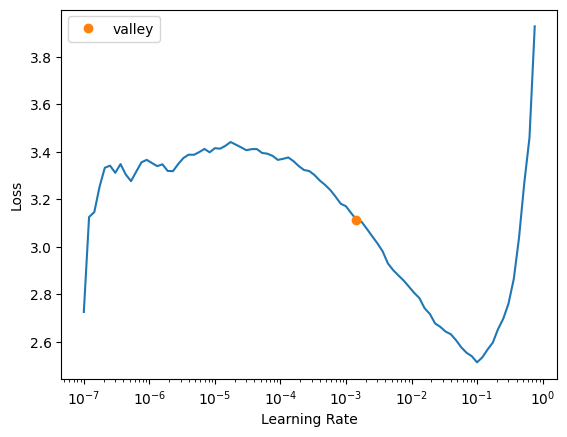

In [14]:
learn16.lr_find()

In [15]:
learn16.fit_one_cycle(20, 1e-3)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,3.125143,1.703118,0.306122,0.262808,0.277513,0.243519,0.671767,00:16
1,2.498838,1.182462,0.505102,0.449560,0.451403,0.438632,0.860272,00:16
2,1.973393,0.909067,0.608844,0.595377,0.601799,0.591425,0.912588,00:18
3,1.609551,0.750477,0.670068,0.686625,0.667549,0.670453,0.931307,00:16
4,1.345590,0.641516,0.685374,0.698275,0.686400,0.682747,0.945018,00:18
5,1.130192,0.522061,0.717687,0.732235,0.737866,0.729097,0.960651,00:17
6,0.977099,0.472270,0.743197,0.768925,0.751804,0.754040,0.963628,00:17
7,0.871925,0.432047,0.763605,0.786417,0.766965,0.772517,0.968490,00:18
8,0.789840,0.407248,0.744898,0.767404,0.748064,0.752521,0.970759,00:17
9,0.719991,0.381537,0.777211,0.800602,0.777237,0.784685,0.973431,00:16


SuggestedLRs(valley=6.30957365501672e-05)

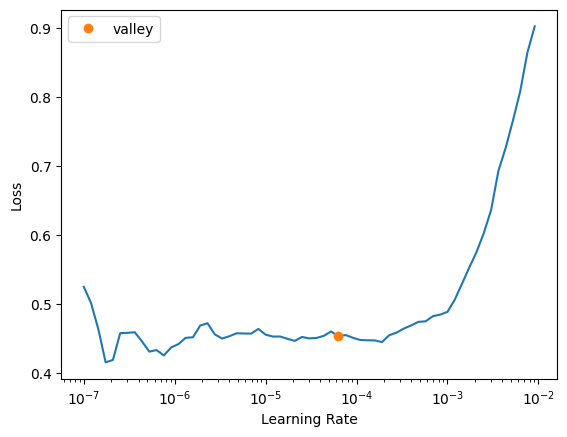

In [16]:
learn16.unfreeze()
learn16.lr_find()

In [17]:
learn16.fit_one_cycle(20, 1e-5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.469687,0.303693,0.804422,0.838080,0.813734,0.821541,0.980598,00:21
1,0.476122,0.297273,0.806122,0.843519,0.816324,0.825976,0.981068,00:23
2,0.464579,0.284176,0.804422,0.840554,0.814331,0.822441,0.982449,00:21
3,0.438907,0.294371,0.806122,0.834970,0.816102,0.821397,0.982036,00:23
4,0.419908,0.263170,0.819728,0.847884,0.829723,0.835911,0.984023,00:22
5,0.399492,0.249595,0.831633,0.852800,0.835799,0.842169,0.985160,00:22
6,0.369642,0.243024,0.840136,0.867831,0.842606,0.851569,0.986606,00:21
7,0.357996,0.232399,0.836735,0.865586,0.849481,0.855039,0.987238,00:23
8,0.349259,0.235548,0.845238,0.868811,0.851086,0.857258,0.986840,00:21
9,0.339037,0.218904,0.846939,0.872801,0.856697,0.862506,0.987855,00:22


In [18]:
learn16.unfreeze()

SuggestedLRs(valley=3.981071586167673e-06)

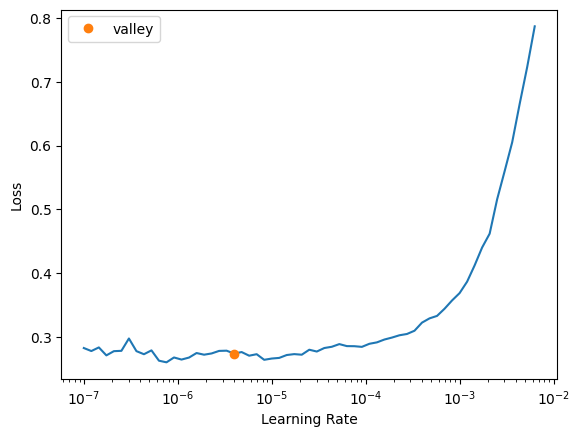

In [19]:
learn16.lr_find()

In [20]:
learn16.fit_one_cycle(20, 1e-6)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,roc_auc_score,time
0,0.293277,0.189133,0.874150,0.889666,0.872177,0.879540,0.990753,00:22
1,0.279419,0.193619,0.872449,0.893730,0.872463,0.881442,0.990562,00:23
2,0.277631,0.190528,0.870748,0.888411,0.871262,0.878394,0.990740,00:21
3,0.278409,0.188334,0.875850,0.894161,0.877244,0.883926,0.990845,00:23
4,0.284869,0.188129,0.874150,0.891906,0.874395,0.880923,0.990871,00:22
5,0.272833,0.183763,0.867347,0.884164,0.865137,0.872254,0.991199,00:23
6,0.276796,0.185050,0.874150,0.890559,0.875378,0.881482,0.991082,00:21
7,0.265395,0.186067,0.874150,0.894151,0.874730,0.882612,0.991086,00:22
8,0.258985,0.191242,0.869048,0.886634,0.867810,0.875056,0.990754,00:21
9,0.275832,0.182662,0.874150,0.885874,0.876919,0.880067,0.991156,00:22
